In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [2]:
df = pd.read_csv('Data/sigma_cabs.csv')
df.shape

(131662, 14)

In [3]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [4]:
### Your code is here

numeric_columns = df.select_dtypes('number').columns
categorical_columns = df.select_dtypes('object').columns

for col in numeric_columns:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

<Axes: >

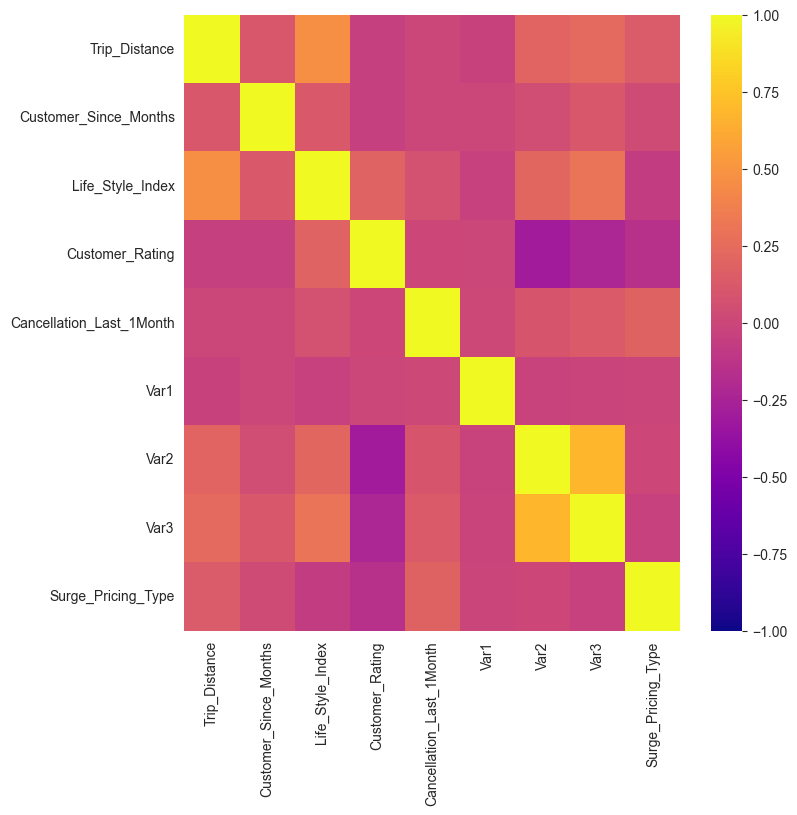

In [8]:
plt.figure(figsize=(8,8))
sns.heatmap(df[numeric_columns].corr(), vmin=-1, vmax=1, cmap='plasma')

In [10]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


print("Top Absolute Correlations")
print(get_top_abs_correlations(df[numeric_columns], 5))

Top Absolute Correlations
Var2              Var3                0.683437
Trip_Distance     Life_Style_Index    0.468332
Life_Style_Index  Var3                0.303324
Customer_Rating   Var2                0.302968
Trip_Distance     Var3                0.231706
dtype: float64


In [11]:
df = pd.concat((df.select_dtypes('number'),
                pd.get_dummies(data=df[categorical_columns], columns=categorical_columns, drop_first=True, dtype=int)),
               axis=1)

### Training

In [12]:
np.random.seed(2022)

from sklearn.model_selection import train_test_split

X = df.drop(columns='Surge_Pricing_Type')
y = df['Surge_Pricing_Type']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

### Your code is here

pipe = Pipeline([('scaler', StandardScaler()),
                 ('one_vs_all', OneVsRestClassifier(LogisticRegression()))])
pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test), digits=3), end='\n\n')

# mico precision, recall, f1-score are all equal to accuracy!
pd.DataFrame(precision_recall_fscore_support(y_test, pipe.predict(X_test), average='micro')[:-1], columns=['micro'],
             index=['precision', 'recall', 'f1-score']).round(3)

              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333




,micro
precision,0.679
recall,0.679
f1-score,0.679


Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [15]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [16]:
### Your code is here
from sklearn.model_selection import GridSearchCV, KFold

kf = KFold()

gs_ova = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=KFold(), scoring='accuracy')
gs_ova.fit(X_train, y_train)

print(classification_report(y_test, gs_ova.predict(X_test), digits=3), end='\n\n')
# mico precision, recall, f1-score are all equal to accuracy!
pd.DataFrame(precision_recall_fscore_support(y_test, gs_ova.predict(X_test), average='micro')[:-1], columns=['micro'],
             index=['precision', 'recall', 'f1-score']).round(3)

              precision    recall  f1-score   support

           1      0.742     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.649      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333




,micro
precision,0.681
recall,0.681
f1-score,0.681


Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

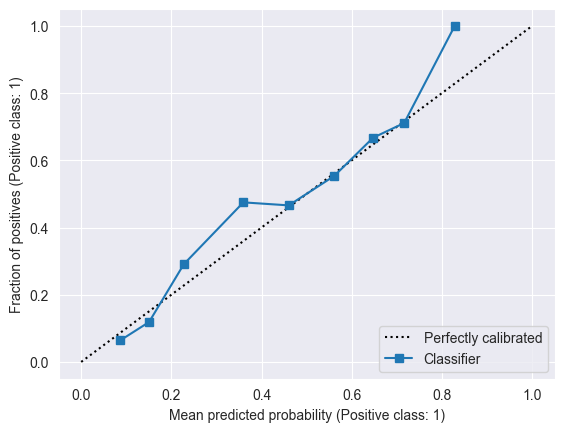

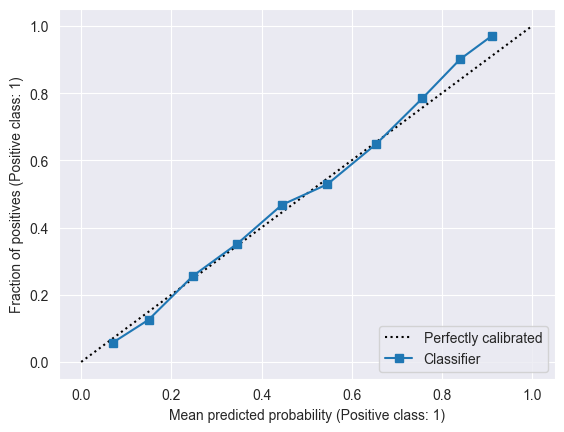

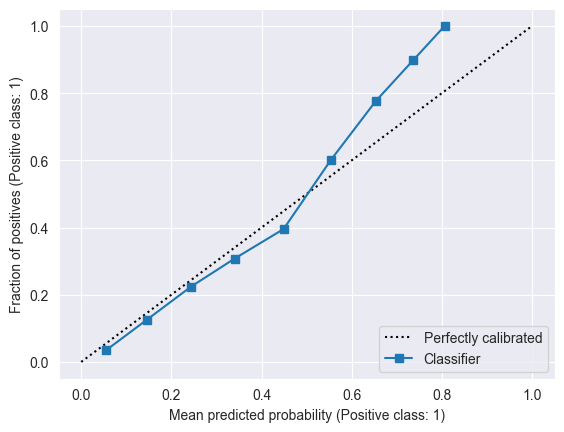

In [22]:
### Your code is here
from sklearn.calibration import CalibrationDisplay

for i in df.Surge_Pricing_Type.unique():
    cab_y_test = y_test.apply(lambda x: 1 if x == i else 0)
    cab_y_prob = gs_ova.predict_proba(X_test)[:, i - 1]
    CalibrationDisplay.from_predictions(cab_y_test, cab_y_prob, n_bins=10)


**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [23]:
### Создание полиномиальных признаков
### Your code is here

X_polinomial = X.copy()

for i in range(len(numeric_columns)):
    if numeric_columns[i] != 'Surge_Pricing_Type':
        for j in range(2, 5):
            X_polinomial[f'{numeric_columns[i]}_{j}'] = X_polinomial[numeric_columns[i]] ** j

In [24]:
X_pol_train, X_pol_test, y_train, y_test = train_test_split(X_polinomial, y,
                                                            test_size=0.2,
                                                            shuffle=True,
                                                            random_state=2022)

In [25]:
### Your code is here
gs_ova.fit(X_pol_train, y_train)

print(classification_report(y_test, gs_ova.predict(X_pol_test), digits=3), end='\n\n')
# mico precision, recall, f1-score are all equal to accuracy!
pd.DataFrame(precision_recall_fscore_support(y_test, gs_ova.predict(X_pol_test), average='micro')[:-1],
             columns=['micro'],
             index=['precision', 'recall', 'f1-score']).round(3)

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.584     0.653      9612

    accuracy                          0.682     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.682     0.677     26333




,micro
precision,0.682
recall,0.682
f1-score,0.682


По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

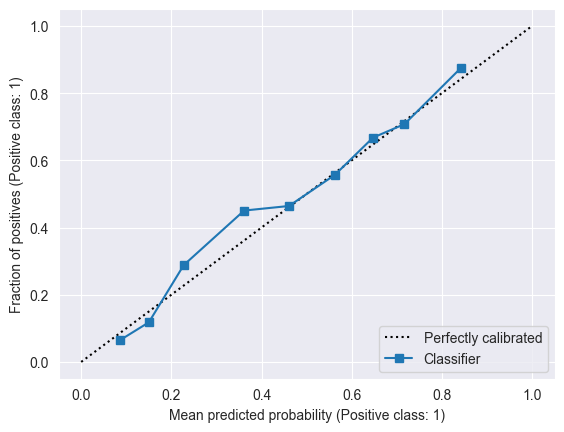

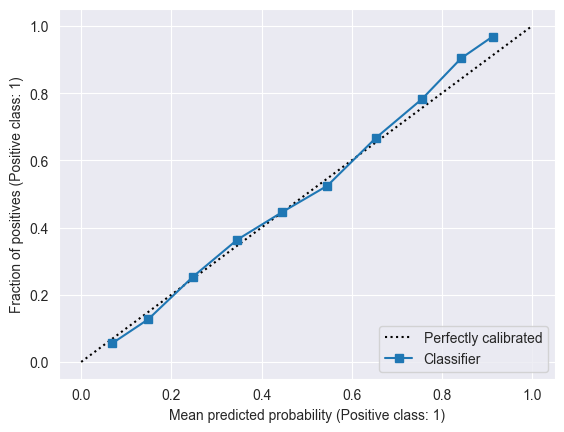

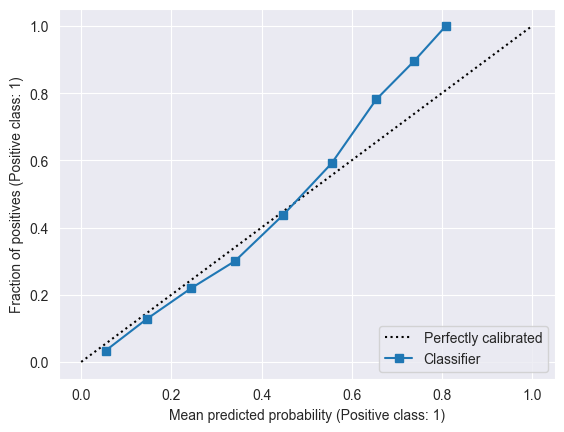

In [26]:
### Your code is here
from sklearn.calibration import CalibrationDisplay

for i in df.Surge_Pricing_Type.unique():
    cab_y_test = y_test.apply(lambda x: 1 if x == i else 0)
    cab_y_prob = gs_ova.predict_proba(X_pol_test)[:, i - 1]
    CalibrationDisplay.from_predictions(cab_y_test, cab_y_prob, n_bins=10)

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=2022)

In [30]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import SGDClassifier
### Your code is here

pipe_ovo = Pipeline([('scaler', StandardScaler()),
                     ('one_vs_one', OneVsOneClassifier(SGDClassifier()))])

param_grid={'one_vs_one__estimator__loss': ['log_loss', 'hinge']}

gs_ovo = GridSearchCV(cv=KFold(), param_grid=param_grid, scoring='accuracy', estimator=pipe_ovo, return_train_score=True)

gs_ovo.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_one',
                                        OneVsOneClassifier(estimator=SGDClassifier()))]),
             param_grid={'one_vs_one__estimator__loss': ['log_loss', 'hinge']},
             return_train_score=True, scoring='accuracy')

In [31]:
gs_ovo.best_params_

{'one_vs_one__estimator__loss': 'hinge'}

In [32]:
gs_ovo.cv_results_.get('mean_train_score')

array([0.67731583, 0.67848599])

In [33]:
gs_ovo.cv_results_.get('mean_test_score')

array([0.67782855, 0.67848362])

In [34]:
print(classification_report(y_test, gs_ovo.predict(X_test), digits=3), end='\n\n')
# mico precision, recall, f1-score are all equal to accuracy!
pd.DataFrame(precision_recall_fscore_support(y_test, gs_ovo.predict(X_test), average='micro')[:-1],
             columns=['micro'],
             index=['precision', 'recall', 'f1-score']).round(3)

              precision    recall  f1-score   support

           1      0.741     0.527     0.616      5372
           2      0.626     0.867     0.727     11349
           3      0.755     0.534     0.625      9612

    accuracy                          0.676     26333
   macro avg      0.707     0.642     0.656     26333
weighted avg      0.696     0.676     0.667     26333




,micro
precision,0.676
recall,0.676
f1-score,0.676


Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [35]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log_loss', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [36]:
### Your code is here

gs_ovo = GridSearchCV(cv=KFold(), param_grid=param_grid, scoring='accuracy', estimator=pipe_ovo)

gs_ovo.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_one',
                                        OneVsOneClassifier(estimator=SGDClassifier()))]),
             param_grid={'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1],
                         'one_vs_one__estimator__loss': ['hinge', 'log_loss',
                                                         'modified_huber'],
                         'one_vs_one__estimator__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [37]:
print(classification_report(y_test, gs_ovo.predict(X_test), digits=3), end='\n\n')
# mico precision, recall, f1-score are all equal to accuracy!
pd.DataFrame(precision_recall_fscore_support(y_test, gs_ovo.predict(X_test), average='micro')[:-1],
             columns=['micro'],
             index=['precision', 'recall', 'f1-score']).round(3)

              precision    recall  f1-score   support

           1      0.755     0.518     0.615      5372
           2      0.625     0.876     0.730     11349
           3      0.762     0.534     0.628      9612

    accuracy                          0.678     26333
   macro avg      0.714     0.643     0.657     26333
weighted avg      0.702     0.678     0.669     26333




,micro
precision,0.678
recall,0.678
f1-score,0.678


Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?